## Review the execution environment

In [1]:
## development environment
# keras=2.2.4
# tensorflow=1.12.0
# dask=1.1.1
import keras
import tensorflow as tf
import dask

import warnings
warnings.filterwarnings('ignore')

print("keras={}".format(keras.__version__))
print("tensorflow={}".format(tf.__version__))
print("dask={}".format(dask.__version__))

/Users/jaejinan/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


keras=2.2.4
tensorflow=1.12.0
dask=1.1.1


## Import module

In [2]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras import backend as K
import numpy as np
import pandas as pd
import os
import cv2
from PIL import Image
import time

## Import and save images

In [ ]:
data=[]
labels=[]
Parasitized=os.listdir("./cell_images/Parasitized/")
for a in Parasitized:
    try:
        image=cv2.imread("./cell_images/Parasitized/"+a)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((64, 64))
        data.append(np.array(size_image))
        labels.append(0)
    except AttributeError:
        print("")

Uninfected=os.listdir("./cell_images/Uninfected/")
for b in Uninfected:
    try:
        image=cv2.imread("./cell_images/Uninfected/"+b)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((64, 64))
        data.append(np.array(size_image))
        labels.append(1)
    except AttributeError:
        print("")
    

In [ ]:
Cells=np.array(data)
labels=np.array(labels)

In [ ]:
np.save("Cells",Cells)
np.save("labels",labels)

## Load Images

In [3]:
Cells=np.load("Cells.npy")
labels=np.load("labels.npy")

## Data preprocessing

In [4]:
s=np.arange(Cells.shape[0])
np.random.shuffle(s)
Cells=Cells[s]
labels=labels[s]

In [5]:
num_classes=len(np.unique(labels))
len_data=len(Cells)

In [6]:
(x_train,x_test)=Cells[(int)(0.1*len_data):],Cells[:(int)(0.1*len_data)]
x_train = x_train.astype('float32')/255 # As we are working on image data we are normalizing data by divinding 255.
x_test = x_test.astype('float32')/255
train_len=len(x_train)
test_len=len(x_test)

In [7]:
(y_train,y_test)=labels[(int)(0.1*len_data):],labels[:(int)(0.1*len_data)]

In [8]:
y_train=keras.utils.to_categorical(y_train,num_classes)
y_test=keras.utils.to_categorical(y_test,num_classes)

In [9]:
img_rows, img_cols = 64,64
img_channels = 3

In [10]:
# Adjustment of input type of dimension number due to difference of backend

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

## Visualization of data

In [11]:
#read library for visualization
%matplotlib inline
import matplotlib.pyplot as plt

In [12]:
#preparing label name
labels = np.array([
    'Parasitized',
    'Uninfected'])

In [13]:
#Store 10 images for each label
img_list = []
for for_1 in range(len(labels)):
    choice_idx = np.random.choice(np.where(y_test == for_1)[0], 10)
    img_list.append(x_test[choice_idx])

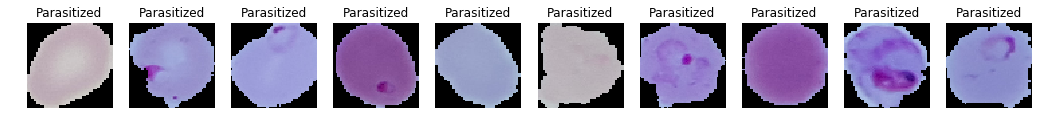

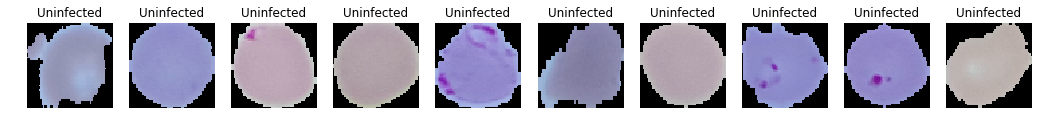

In [14]:
# Visualization of data
for for_1 in range(len(labels)):
    fig, ax = plt.subplots(1, 10, figsize=(18, 8))
    for for_2 in range(10):
        ax[for_2].imshow(img_list[for_1][for_2].reshape(64, 64, 3)) #Outputs the nth and subsequent test data with the value of for_2 + n
        ax[for_2].set_title(labels[for_1])
        ax[for_2].axis('off')

## Building a model

In [15]:
model=Sequential()
model.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(500,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(2,activation="softmax"))#2represent output layer neurons 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 16)        208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)          0         
__________

## Set model optimization function and error function

In [16]:
from keras.optimizers import Adam

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

## Save model and parameters

In [17]:
#Save model in JSON format
json_string = model.to_json()
open('./cell_cnn.json', 'w').write(json_string)

3797

In [18]:
#Save initial weight
model.save_weights('./cell_cnn_init_weight.hdf5', overwrite=True)

## Reading models and calling parameters

In [33]:
from keras.models import model_from_json, model_from_yaml
#Calling models saved in JSON format
json_string = open('./cell_cnn.json', 'r').read()
model = model_from_json(json_string)
model.load_weights('./cell_cnn_init_weight.hdf5')

## Learning

In [19]:
#See progress of learning at TensorBoard
tb_cb = keras.callbacks.TensorBoard(log_dir='/tmp/keras_cnn', histogram_freq=1)

# If the validation loss decreases, save the model for each epoch
cp_cb = keras.callbacks.ModelCheckpoint(filepath='./cell_cnn_best_weight1.hdf5', 
                                        monitor='val_loss', 
                                        verbose=1, 
                                        save_best_only=True, 
                                        mode='auto')

# If the validation loss rises for 5 epochs in a row, the run is aborted
es_cb = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=5, 
                                      verbose=0, 
                                      mode='auto')

cbks = [tb_cb, cp_cb, es_cb]

In [20]:
#Perform learning
#The value of loss function in learning is stored in history.history
history = model.fit(x_train, y_train,
                    batch_size=128,  #128 datas are randomly obtained
                    nb_epoch=50, #Number of trials
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=cbks)

Train on 24803 samples, validate on 2755 samples
Epoch 1/50
24803/24803 [==============================] - 40s 2ms/step - loss: 0.4575 - acc: 0.7782 - val_loss: 0.2130 - val_acc: 0.9176

Epoch 00001: val_loss improved from inf to 0.21302, saving model to ./cell_cnn_best_weight1.hdf5
Epoch 2/50
24803/24803 [==============================] - 40s 2ms/step - loss: 0.1841 - acc: 0.9366 - val_loss: 0.1505 - val_acc: 0.9495

Epoch 00002: val_loss improved from 0.21302 to 0.15049, saving model to ./cell_cnn_best_weight1.hdf5
Epoch 3/50
24803/24803 [==============================] - 40s 2ms/step - loss: 0.1502 - acc: 0.9502 - val_loss: 0.1419 - val_acc: 0.9550

Epoch 00003: val_loss improved from 0.15049 to 0.14185, saving model to ./cell_cnn_best_weight1.hdf5
Epoch 4/50
24803/24803 [==============================] - 39s 2ms/step - loss: 0.1390 - acc: 0.9551 - val_loss: 0.1334 - val_acc: 0.9550

Epoch 00004: val_loss improved from 0.14185 to 0.13340, saving model to ./cell_cnn_best_weight1.hdf5

## Calling the best parameter

In [21]:
model.load_weights('./cell_cnn_best_weight1.hdf5')

## Evaluation of learning result

In [22]:
#Evaluation value for test data
score = model.evaluate(x_test, y_test, verbose=0)
print('Test score:', score[0]) #The value of the loss function
print('Test accuracy:', score[1]) #Accuracy (over 98%)

Test score: 0.12579340105403058
Test accuracy: 0.958983666061706


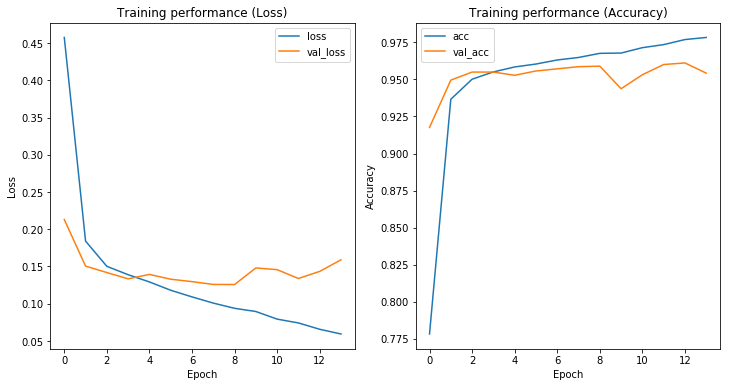

In [23]:
#Learning curve
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title('Training performance (Loss)')
ax[0].plot(history.epoch, history.history['loss'], label='loss')
ax[0].plot(history.epoch, history.history['val_loss'], label='val_loss')
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[0].legend()

ax[1].set_title('Training performance (Accuracy)')
ax[1].plot(history.epoch, history.history['acc'], label='acc')
ax[1].plot(history.epoch, history.history['val_acc'], label='val_acc')
ax[1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1].legend(loc='best')

## Predictive visualization

In [24]:
#Predicted value
#Store 10 images for each label
New_test = []
for for_1 in range(10):
    choice_idx = np.random.choice(np.where(y_test == (for_1%2))[0])
    New_test.append(x_test[choice_idx])
New_test = np.array(New_test)
# Estimate the label of the image
Y_test_pred = model.predict(New_test)

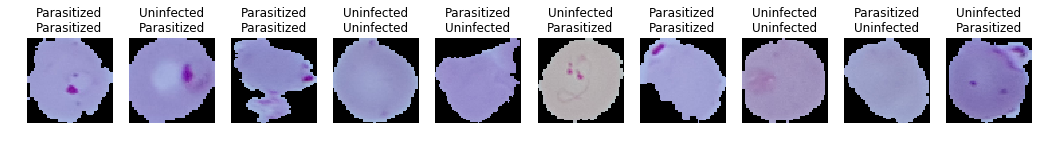

In [25]:
#Data visualization
#The upper row is the correct label, and lower row is the guess label
fig, ax = plt.subplots(1, 10, figsize=(18, 8))
for for_1 in range(10):
    ax[for_1].imshow(New_test[for_1].reshape(64,64, 3)) #Outputs the nth and subsequent test data with the value of for_2 + n
    ax[for_1].set_title(labels[(for_1%2)]+"\n"+labels[np.argmax(Y_test_pred[for_1])])
    ax[for_1].axis('off')

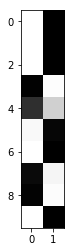

In [26]:
#Predictive visualization
#Numerals of images passed by Y axis, and X axis is estimated by neural network
plt.imshow(Y_test_pred[:10], cmap='gray', interpolation='nearest', vmin=0, vmax=1) #Y_test_predの範囲を変えることで予測の場所を変更できる